## Supervised Learning Potpourri
# 3 - Housing Prices
### Sam Fradkin

Using [this Kaggle data](https://www.kaggle.com/anthonypino/melbourne-housing-market) create a model to predict a house's value. We want to be able to understand what creates value in a house, as though we were a real estate developer.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

import re

import warnings
warnings.filterwarnings('ignore')

# 1) Data Overview

Let's take a look at the data provided to us.

In [2]:
df = pd.read_csv('Melbourne Housing.csv')

In [3]:
df.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Postcode,Regionname,Propertycount,Distance,CouncilArea
0,Abbotsford,49 Lithgow St,3,h,1490000.0,S,Jellis,1/04/2017,3067,Northern Metropolitan,4019,3.0,Yarra City Council
1,Abbotsford,59A Turner St,3,h,1220000.0,S,Marshall,1/04/2017,3067,Northern Metropolitan,4019,3.0,Yarra City Council
2,Abbotsford,119B Yarra St,3,h,1420000.0,S,Nelson,1/04/2017,3067,Northern Metropolitan,4019,3.0,Yarra City Council
3,Aberfeldie,68 Vida St,3,h,1515000.0,S,Barry,1/04/2017,3040,Western Metropolitan,1543,7.5,Moonee Valley City Council
4,Airport West,92 Clydesdale Rd,2,h,670000.0,S,Nelson,1/04/2017,3042,Western Metropolitan,3464,10.4,Moonee Valley City Council


In [4]:
df.shape

(63023, 13)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63023 entries, 0 to 63022
Data columns (total 13 columns):
Suburb           63023 non-null object
Address          63023 non-null object
Rooms            63023 non-null int64
Type             63023 non-null object
Price            48433 non-null float64
Method           63023 non-null object
SellerG          63023 non-null object
Date             63023 non-null object
Postcode         63023 non-null int64
Regionname       63023 non-null object
Propertycount    63023 non-null int64
Distance         63023 non-null float64
CouncilArea      63023 non-null object
dtypes: float64(2), int64(3), object(8)
memory usage: 6.3+ MB


In [6]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Rooms,63023.0,3.110595,0.957551,1.0,3.0,3.0,4.0,31.0
Price,48433.0,997898.241488,593498.919037,85000.0,620000.0,830000.0,1220000.0,11200000.0
Postcode,63023.0,3125.673897,125.626877,3000.0,3056.0,3107.0,3163.0,3980.0
Propertycount,63023.0,7617.728131,4424.423167,39.0,4380.0,6795.0,10412.0,21650.0
Distance,63023.0,12.684829,7.592015,0.0,7.0,11.4,16.7,64.1


In [7]:
df.nunique()

Suburb             380
Address          57754
Rooms               14
Type                 3
Price             3417
Method               9
SellerG            476
Date               112
Postcode           225
Regionname           8
Propertycount      368
Distance           180
CouncilArea         34
dtype: int64

# 2) Data Cleaning

Here we will make sure all features are usable for prediction purposes as well as removing all unnecessary data.

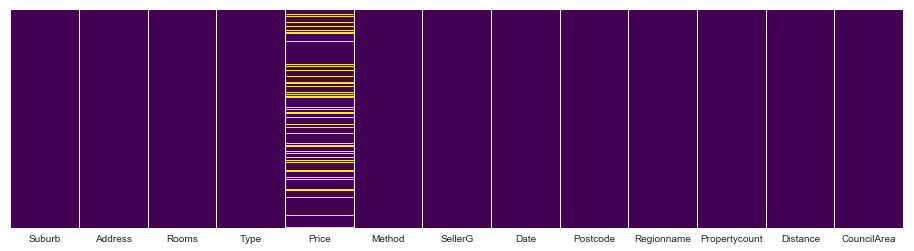

In [8]:
# Create a heatmap of null values to see how prevalent they are and how to address them
plt.figure(figsize=(16,4))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.show()

It looks like our Price column is missing a lot of data. Being that Price is our target feature, let's see if we can use those rows in our test set.<br><br>
Now let's see if we can convert any of the object-type columns into usable features.

In [9]:
# Make the categorical variable 'Type' into dummies
df = pd.concat([df, pd.get_dummies(df['Type'])], axis = 1)

# Remove the original 'Type' column and rename the new columns
df.drop(['Type'], axis = 1, inplace = True)
df.rename(columns={'h': 'Type-H', 't': 'Type-T', 'u': 'Type-U'}, inplace=True)

In [10]:
# Drop unusable columns
df = df.drop(['Address', 'SellerG', 'Date'], 1)

In [11]:
suburb  = df['Suburb'     ].tolist()
method  = df['Method'     ].tolist()
region  = df['Regionname' ].tolist()
council = df['CouncilArea'].tolist()

In [12]:
df['Suburb'     ] = df['Suburb'     ].apply(lambda x: suburb.index(x) + 1)
df['Method'     ] = df['Method'     ].apply(lambda x: method.index(x) + 1)
df['Regionname' ] = df['Regionname' ].apply(lambda x: region.index(x) + 1)
df['CouncilArea'] = df['CouncilArea'].apply(lambda x: council.index(x)+ 1)

In [13]:
df.head()

,Suburb,Rooms,Price,Method,Postcode,Regionname,Propertycount,Distance,CouncilArea,Type-H,Type-T,Type-U
0,1,3,1490000.0,1,3067,1,4019,3.0,1,1,0,0
1,1,3,1220000.0,1,3067,1,4019,3.0,1,1,0,0
2,1,3,1420000.0,1,3067,1,4019,3.0,1,1,0,0
3,4,3,1515000.0,1,3040,4,1543,7.5,4,1,0,0
4,5,2,670000.0,1,3042,4,3464,10.4,4,1,0,0


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63023 entries, 0 to 63022
Data columns (total 12 columns):
Suburb           63023 non-null int64
Rooms            63023 non-null int64
Price            48433 non-null float64
Method           63023 non-null int64
Postcode         63023 non-null int64
Regionname       63023 non-null int64
Propertycount    63023 non-null int64
Distance         63023 non-null float64
CouncilArea      63023 non-null int64
Type-H           63023 non-null uint8
Type-T           63023 non-null uint8
Type-U           63023 non-null uint8
dtypes: float64(2), int64(7), uint8(3)
memory usage: 4.5 MB
